Just re-running Derek's notebook to recreate the same object that produces the same figure and colors.

In [1]:
#import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import scanpy as sc
import scipy
scipy.__version__

'1.4.1'

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)

In [3]:
prefix = "/data/xyzeq/xyzeq/individual.raw.and.proc.h5ads/"

In [22]:
adata=sc.read(prefix + '20190920_L20C1_files/matrix.mtx', cache=False).T

adata.var_names = [gene.strip() for gene in open(prefix + '20190920_L20C1_files/genes.tsv', 'r')]
adata.obs_names = [barcode.strip() for barcode in open(prefix + '20190920_L20C1_files/barcodes.tsv', 'r')] 

    reading /data/xyzeq/xyzeq/individual.raw.and.proc.h5ads/20190920_L20C1_files/matrix.mtx
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [23]:
adata.var_names_make_unique()

In [24]:
adata=adata[adata.obs_names.str.contains('L20C1')].copy()

In [25]:
adata.obs_names

Index(['L20C1_P1A01F.GACCGTCTCATAGCGC', 'L20C1_P1A01F.GCCTCTTAGATAGACA',
       'L20C1_P1A01F.GATCCGTCGTCAGACT', 'L20C1_P1A01F.GGTCACCACTTACAGT',
       'L20C1_P1A01F.TTACCGTTGGCCAATA', 'L20C1_P1A01F.TCAACAGAACCACCGA',
       'L20C1_P1A01F.GCAGTACAGACCAGGC', 'L20C1_P1A01F.TAGCCACAAGCGGACA',
       'L20C1_P1A01F.GTCCATGATTAGTAGC', 'L20C1_P1A01F.CTCCTGTCCAAGACAT',
       ...
       'L20C1_P4H12F.TCCACCGTATGCGCTG', 'L20C1_P4H12F.ATCTCTTGTCTTGGCG',
       'L20C1_P4H12F.CTCTTGGAGGTCTTCG', 'L20C1_P4H12F.TACCACGCCTACCAGC',
       'L20C1_P4H12F.CGAGGCTATGCGTTGG', 'L20C1_P4H12F.CTGGTAATAAGAGCGC',
       'L20C1_P4H12F.TACGTGCTAACTGCTA', 'L20C1_P4H12F.TCCGAACCGAGATTAA',
       'L20C1_P4H12F.CATGCGTGCTCTTACG', 'L20C1_P4H12F.ATCGAATGCGCCACCG'],
      dtype='object', length=26436)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


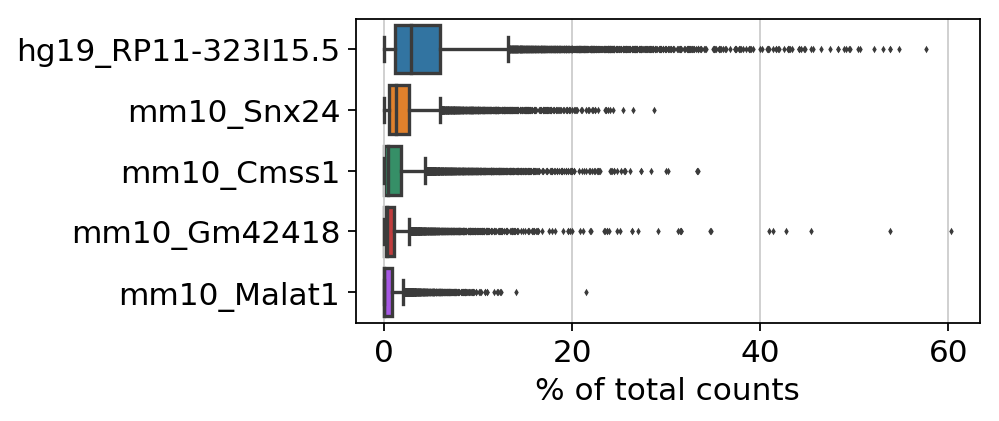

In [26]:
sc.pl.highest_expr_genes(adata, n_top=5) 

In [27]:
adata

AnnData object with n_obs × n_vars = 26436 × 121472 

In [28]:
##post processing filter minimum UMIS and genes
sc.pp.filter_cells(adata, min_counts=500)#300
sc.pp.filter_cells(adata, min_genes=100)

##post processing filter genes 
sc.pp.filter_genes(adata, min_cells=2)
#sc.pp.filter_genes(adata, max_cells=1000)   

## define mito genes 
mito_genes=[name for name in adata.var_names if name.startswith(('mm10_mt-', 'hg19_mt-', 'mt-'))]

##create new obs anotation to define percent mito for each cell 
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)*100

##create new obs anotation to define UMIs per cell
adata.obs['n_counts'] = adata.X.sum(axis=1)

filtered out 18293 cells that haveless than 500 counts
filtered out 3 cells that haveless than 100 genes expressed
filtered out 71226 genes that are detectedin less than 2 cells


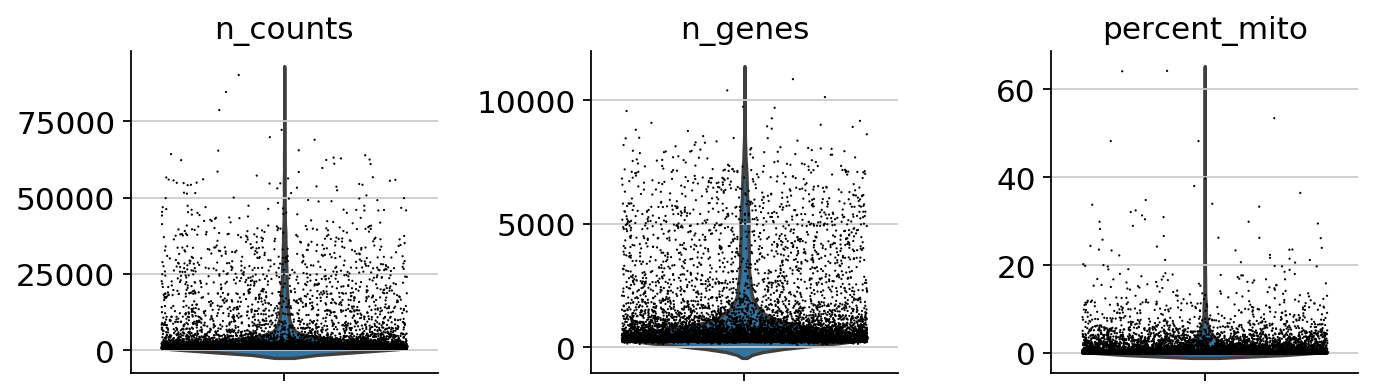

In [29]:
sc.pl.violin(adata, ['n_counts', 'n_genes', 'percent_mito'], jitter=0.4, multi_panel=True)

In [30]:
spec_filter= [name for name in adata.var_names if not name.startswith('mm10_Itgam')]
adata=adata[:, spec_filter].copy()

In [31]:
spec_filter= [name for name in adata.var_names if not name.startswith('mm10_Smim20')]
adata=adata[:, spec_filter].copy()

In [32]:
spec_filter= [name for name in adata.var_names if not name.startswith('hg19_RP11-323I15.5')]
adata=adata[:, spec_filter].copy()

In [33]:
adata.shape

(8140, 50241)

In [34]:
##filter out outliers
adata = adata[adata.obs['n_genes'] < 15000, :].copy()

In [35]:
adata.shape

(8140, 50241)

In [36]:
adata = adata[adata.obs['n_counts'] < 10000, :].copy()

In [37]:
adata.shape

(7151, 50241)

In [38]:
adata = adata[adata.obs['percent_mito'] < 1, :].copy()

In [39]:
adata.shape

(4788, 50241)

In [ ]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [ ]:
#barnyard
mouse_genes=[name for name in adata.var_names if name.startswith('mm10_')]
human_genes=[name for name in adata.var_names if name.startswith('hg19_')]

adata.obs['mouse_counts'] = np.sum(adata[:, mouse_genes].X, axis=1)
adata.obs['human_counts'] = np.sum(adata[:, human_genes].X, axis=1)

In [18]:
cmap = mpl.colors.ListedColormap(['royalblue','lightgrey', 'orangered'])

In [19]:
np.seterr(divide = 'ignore') 
adata.obs['ratio'] = np.log10(np.true_divide(adata.obs['mouse_counts'], adata.obs['human_counts']))

def cell_call(counts):
        if counts['ratio'] > 0.66:
                return 'M'
        elif counts['ratio'] < -0.66:
                return 'H'
        else:
                return 'C'

adata.obs['cell_call']=adata.obs.apply(lambda counts: cell_call(counts), axis=1)

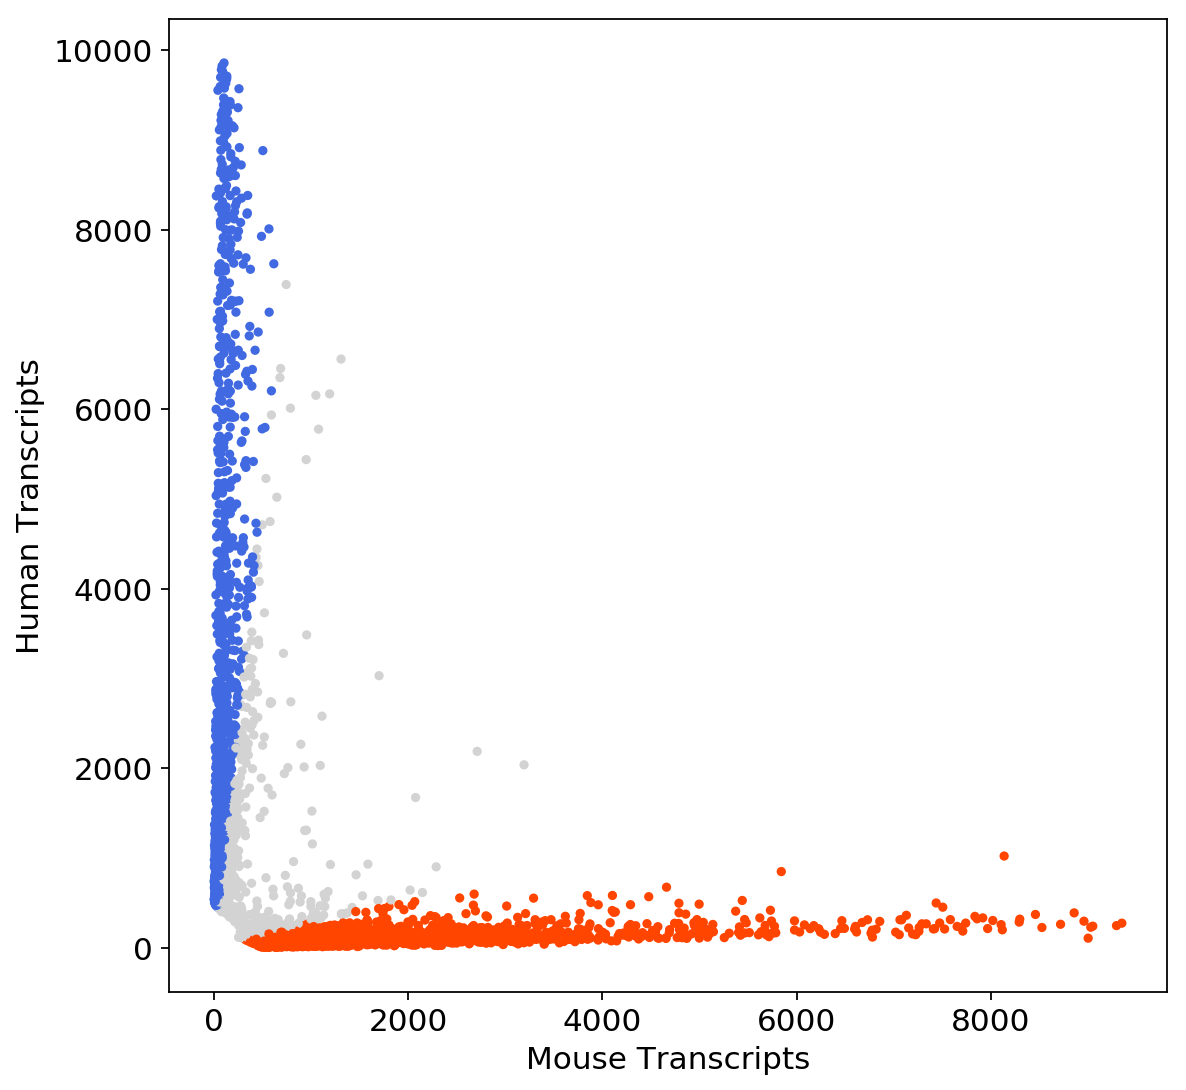

In [20]:
plt.rcParams['figure.figsize'] = [8, 8]

plt.scatter(x=adata.obs['mouse_counts'], 
            y=adata.obs['human_counts'],
            s=10,
            c=adata.obs['ratio'],
           cmap=cmap)


plt.xlabel('Mouse Transcripts')
plt.ylabel('Human Transcripts')
plt.grid(b=False)

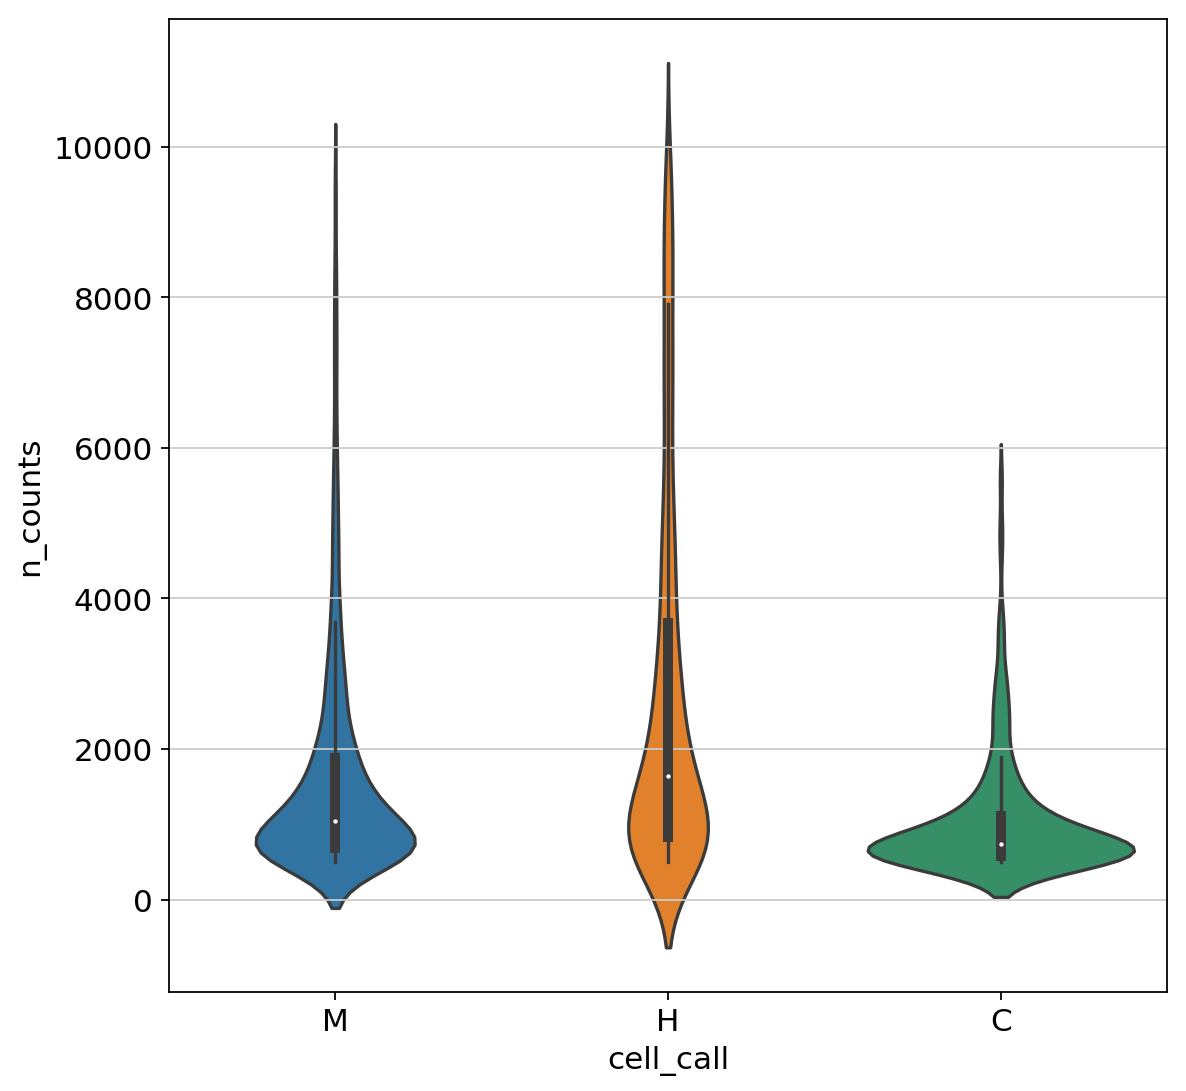

In [21]:
sns.violinplot(data=adata.obs, x='cell_call', y='n_counts');

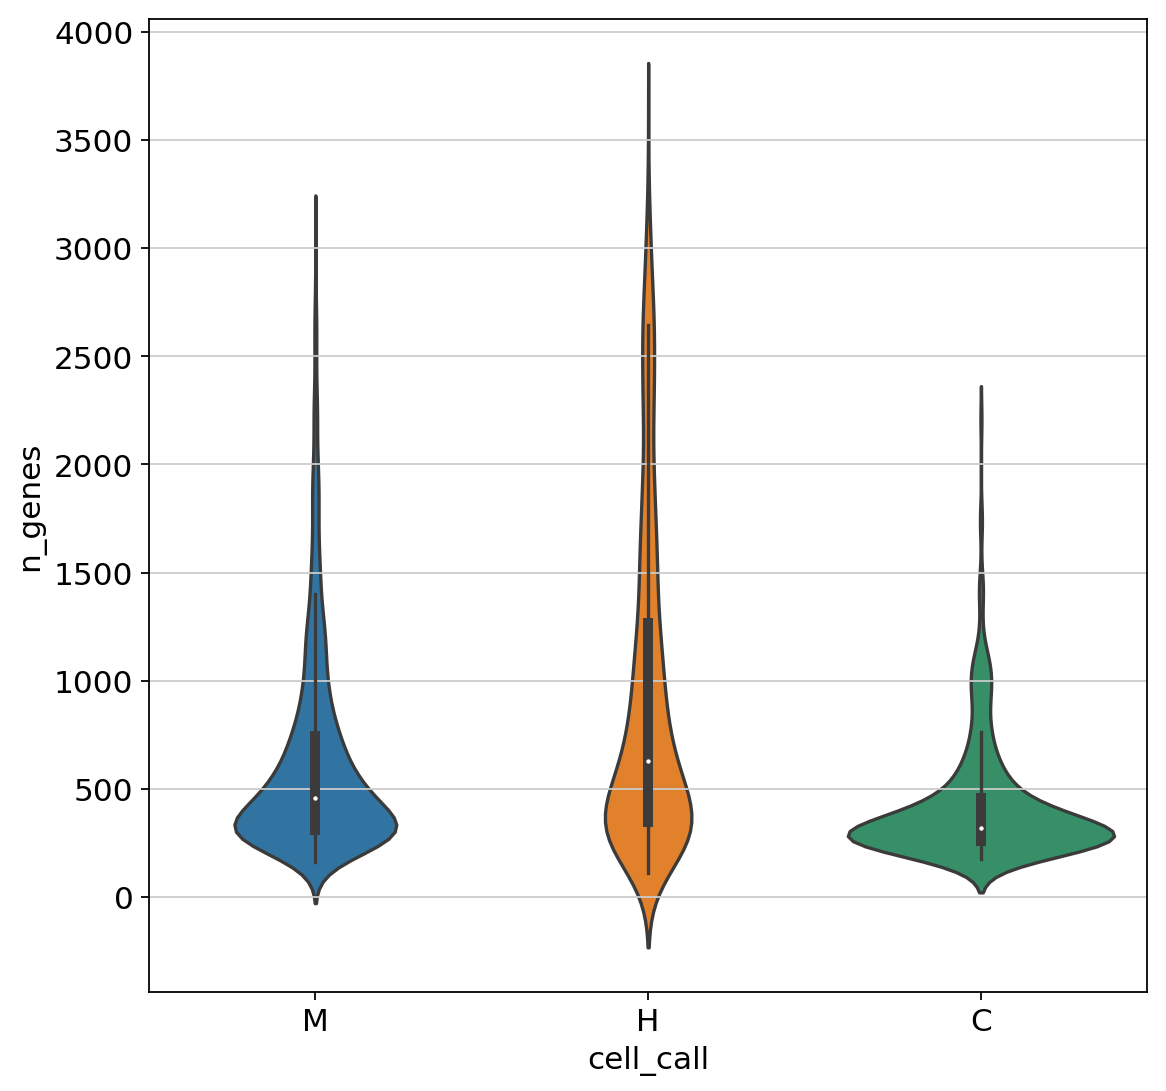

In [22]:
sns.violinplot(data=adata.obs,x='cell_call',y='n_genes');

In [23]:
adata.obs['cell_call'].value_counts()

M    2700
H    1625
C     463
Name: cell_call, dtype: int64

In [24]:
np.median(adata[adata.obs['cell_call']=='M'].obs.n_genes)

456.0

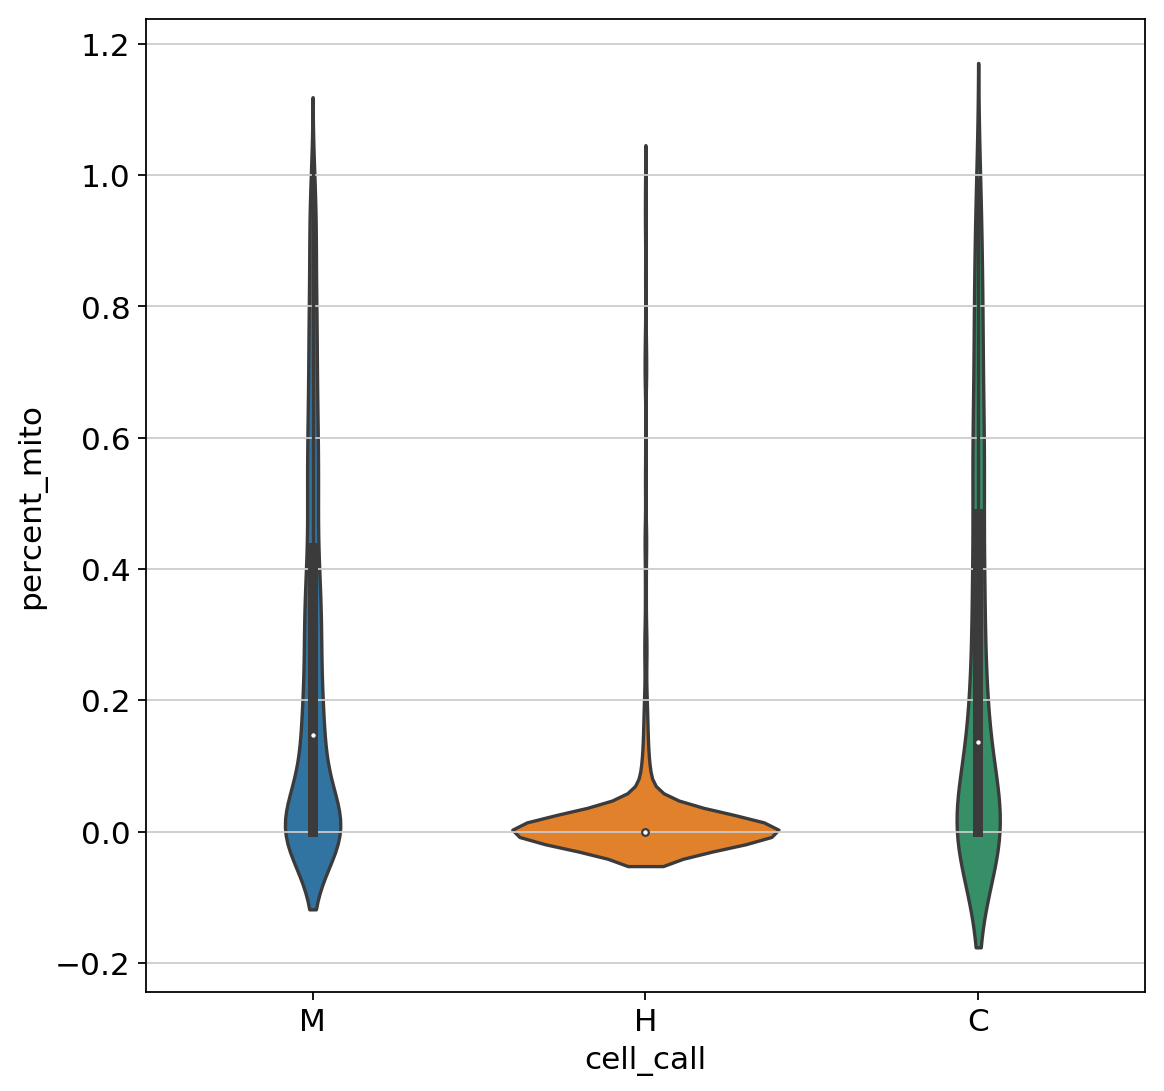

In [25]:
sns.violinplot(data=adata.obs,x='cell_call',y='percent_mito');

In [26]:
adata.write_h5ad(prefix + 'fig3.L20C1/adata.1.h5ad')

... storing 'cell_call' as categorical


In [27]:
# I skip this, the raw attribute in Scanpy really sucks
# adata.raw = sc.pp.log1p(adata, copy=True)

In [28]:
##normalize counts per cell to 10K each 
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [29]:
print(adata.X.sum(axis=1))

[[10000.   ]
 [ 9999.999]
 [ 9999.999]
 ...
 [10000.   ]
 [10000.   ]
 [10000.002]]


In [30]:
adata.shape

(4788, 50241)

extracting highly variable genes
    Gene indices [27844, 48550, 49318] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:02)


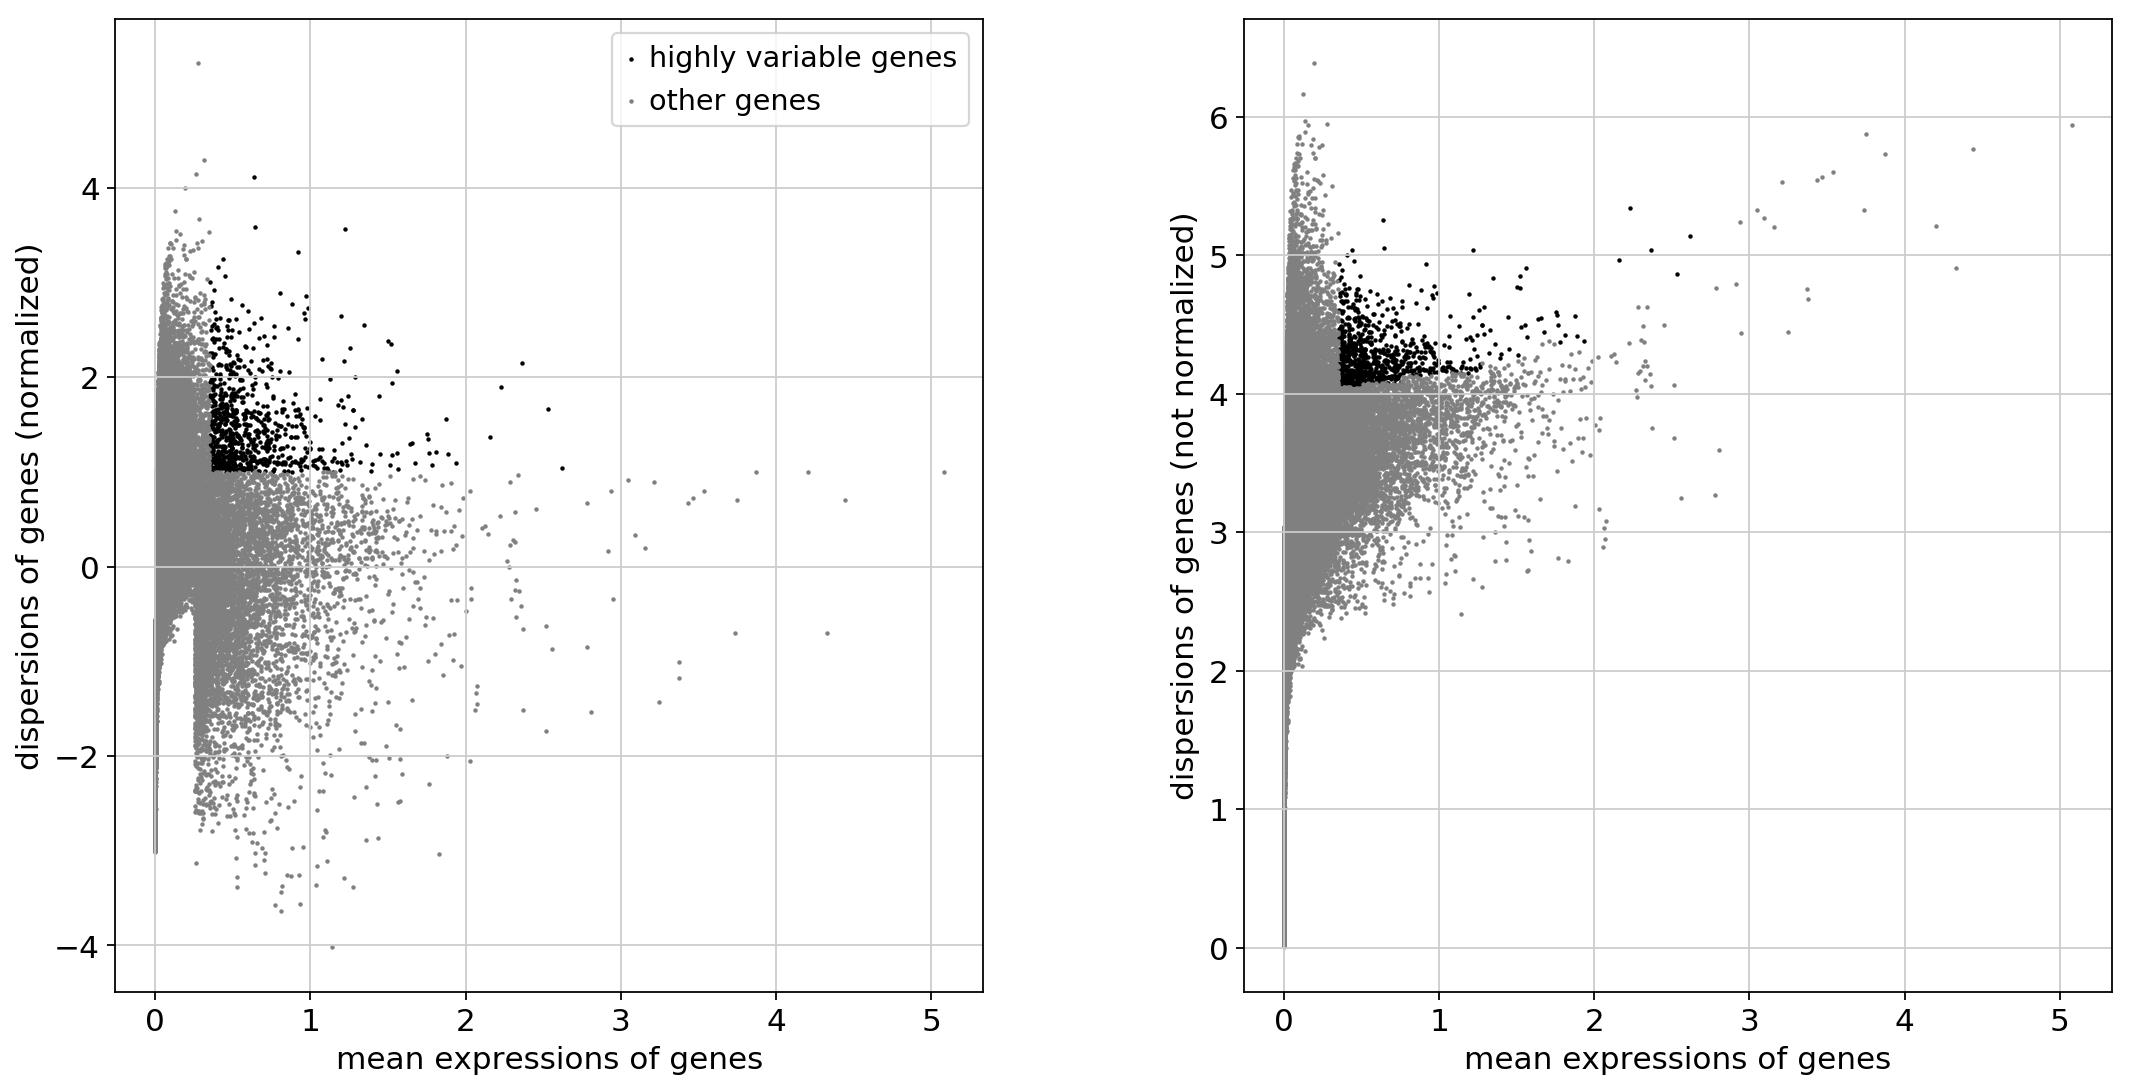

In [31]:
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.35, max_mean=7, min_disp=1) ####L20C1 parameters     
sc.pl.filter_genes_dispersion(filter_result)

In [32]:
filter_result

rec.array([(False, 1.1702676e-03, 0.3601469, -2.6226435 ),
           (False, 1.0000000e-12,       nan,         nan),
           (False, 1.1697747e-02, 2.2933307, -0.49871537), ...,
           (False, 1.4190648e+00, 3.334681 , -1.4423524 ),
           (False, 2.6195091e-01, 3.5203967, -0.20583872),
           (False, 3.8959142e-03, 2.3415518, -0.44573635)],
          dtype=[('gene_subset', '?'), ('means', '<f4'), ('dispersions', '<f4'), ('dispersions_norm', '<f4')])

In [33]:
sum(filter_result.gene_subset)

789

In [34]:
#percent of genes that are highly variable
sum(filter_result.gene_subset)/len(filter_result.gene_subset)*100

1.570430524870126

In [35]:
adata = adata[:, filter_result.gene_subset].copy()

In [36]:
adata

AnnData object with n_obs × n_vars = 4788 × 789 
    obs: 'n_counts', 'n_genes', 'percent_mito', 'mouse_counts', 'human_counts', 'ratio', 'cell_call'
    var: 'n_cells'

In [37]:
adata.write_h5ad(prefix + 'fig3.L20C1/adata.2.h5ad')

In [38]:
sc.pp.log1p(adata)

In [39]:
adata.write_h5ad(prefix + 'fig3.L20C1/adata.3.h5ad')

In [40]:
adata.X

<4788x789 sparse matrix of type '<class 'numpy.float32'>'
	with 172497 stored elements in Compressed Sparse Row format>

In [41]:
#Regress out unwanted sources of variation
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:04)


In [42]:
adata.write_h5ad(prefix + 'fig3.L20C1/adata.4.h5ad')

In [43]:
sc.pp.scale(adata, max_value=10)

    ... clipping at max_value 10


In [44]:
adata.write_h5ad(prefix + 'fig3.L20C1/adata.5.h5ad')

In [45]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
    finished (0:00:00)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


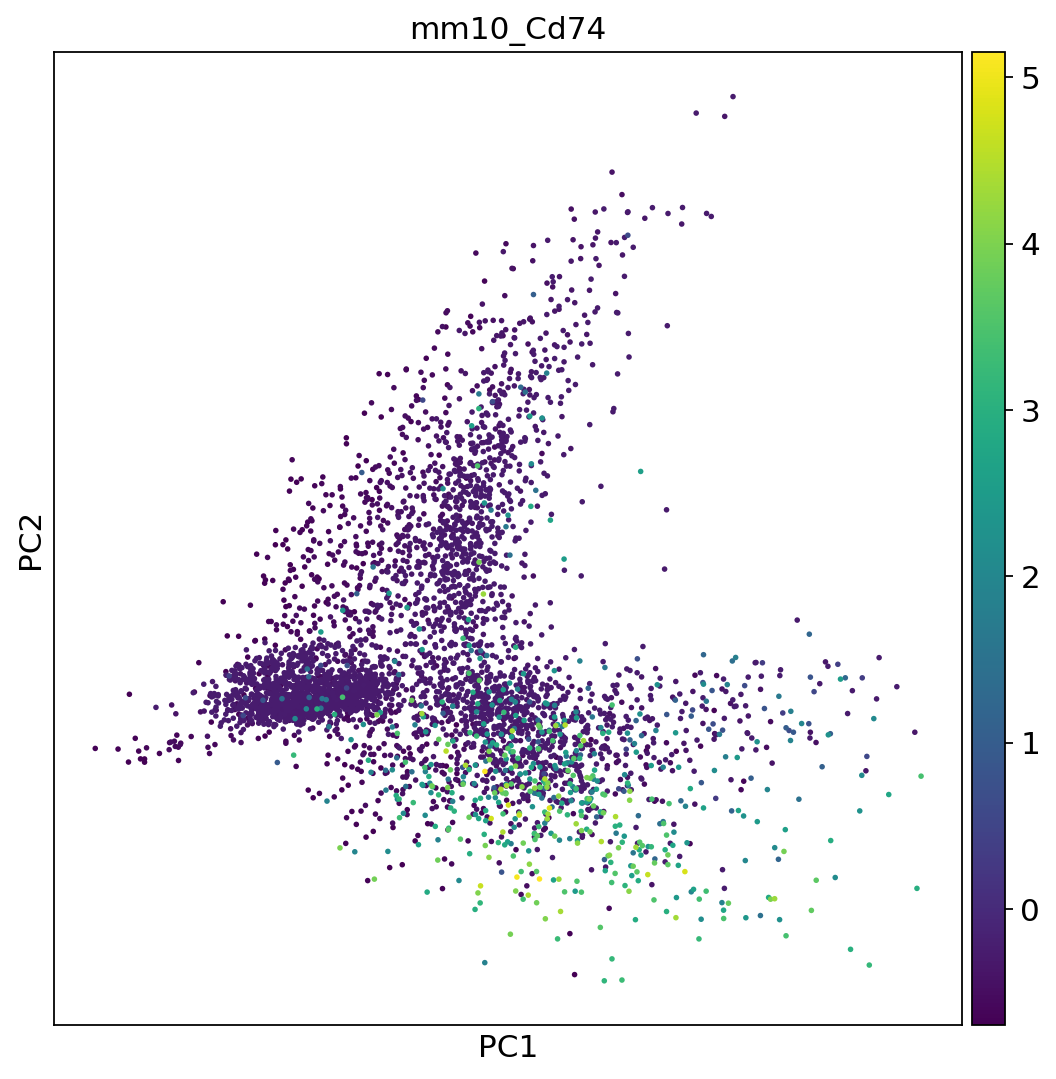

In [46]:
sc.pl.pca(adata,color='mm10_Cd74')

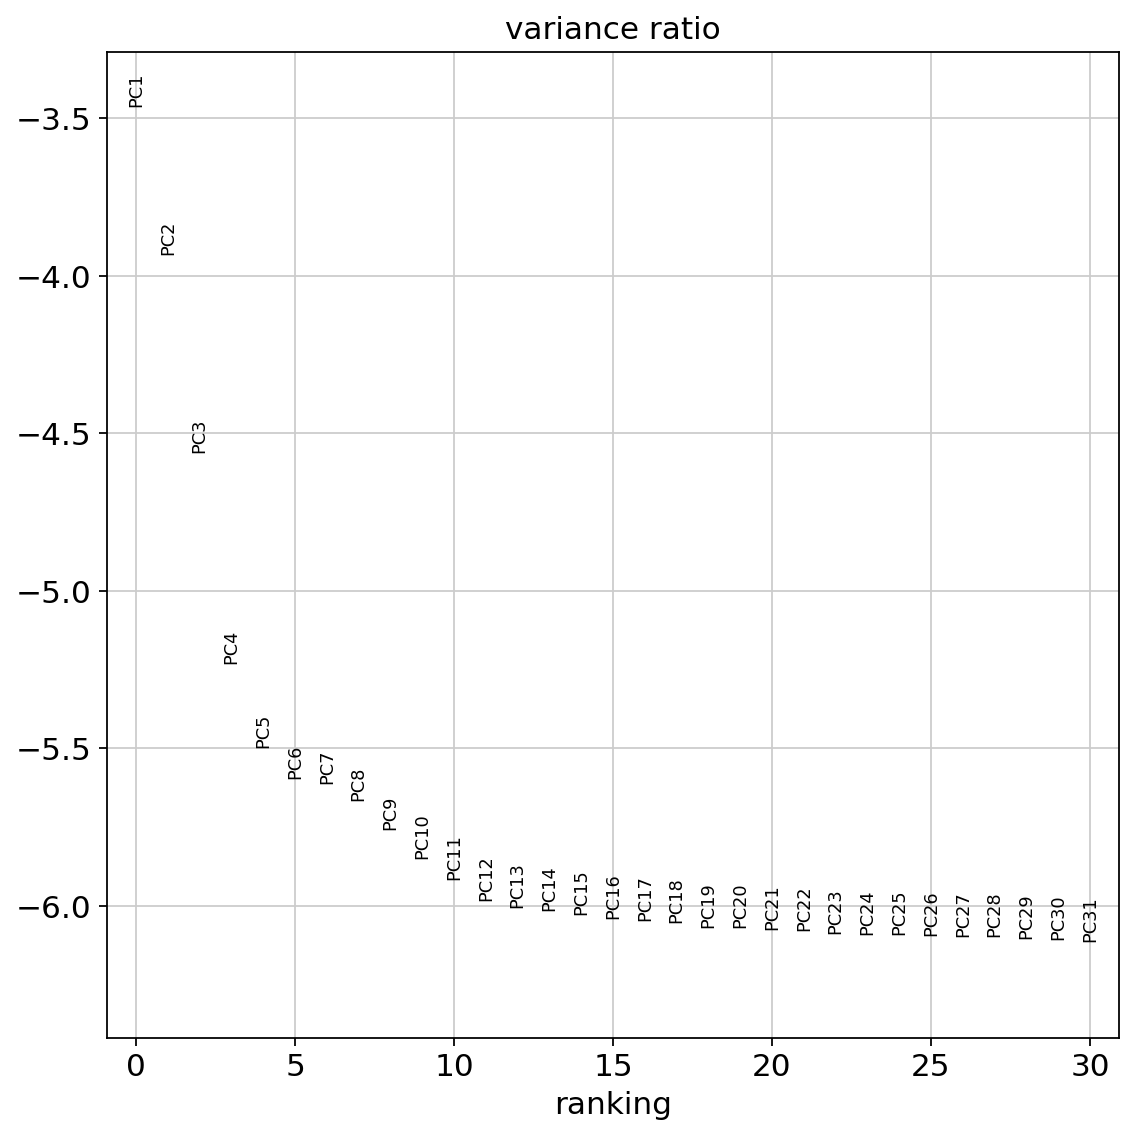

In [47]:
sc.pl.pca_variance_ratio(adata, log=True)

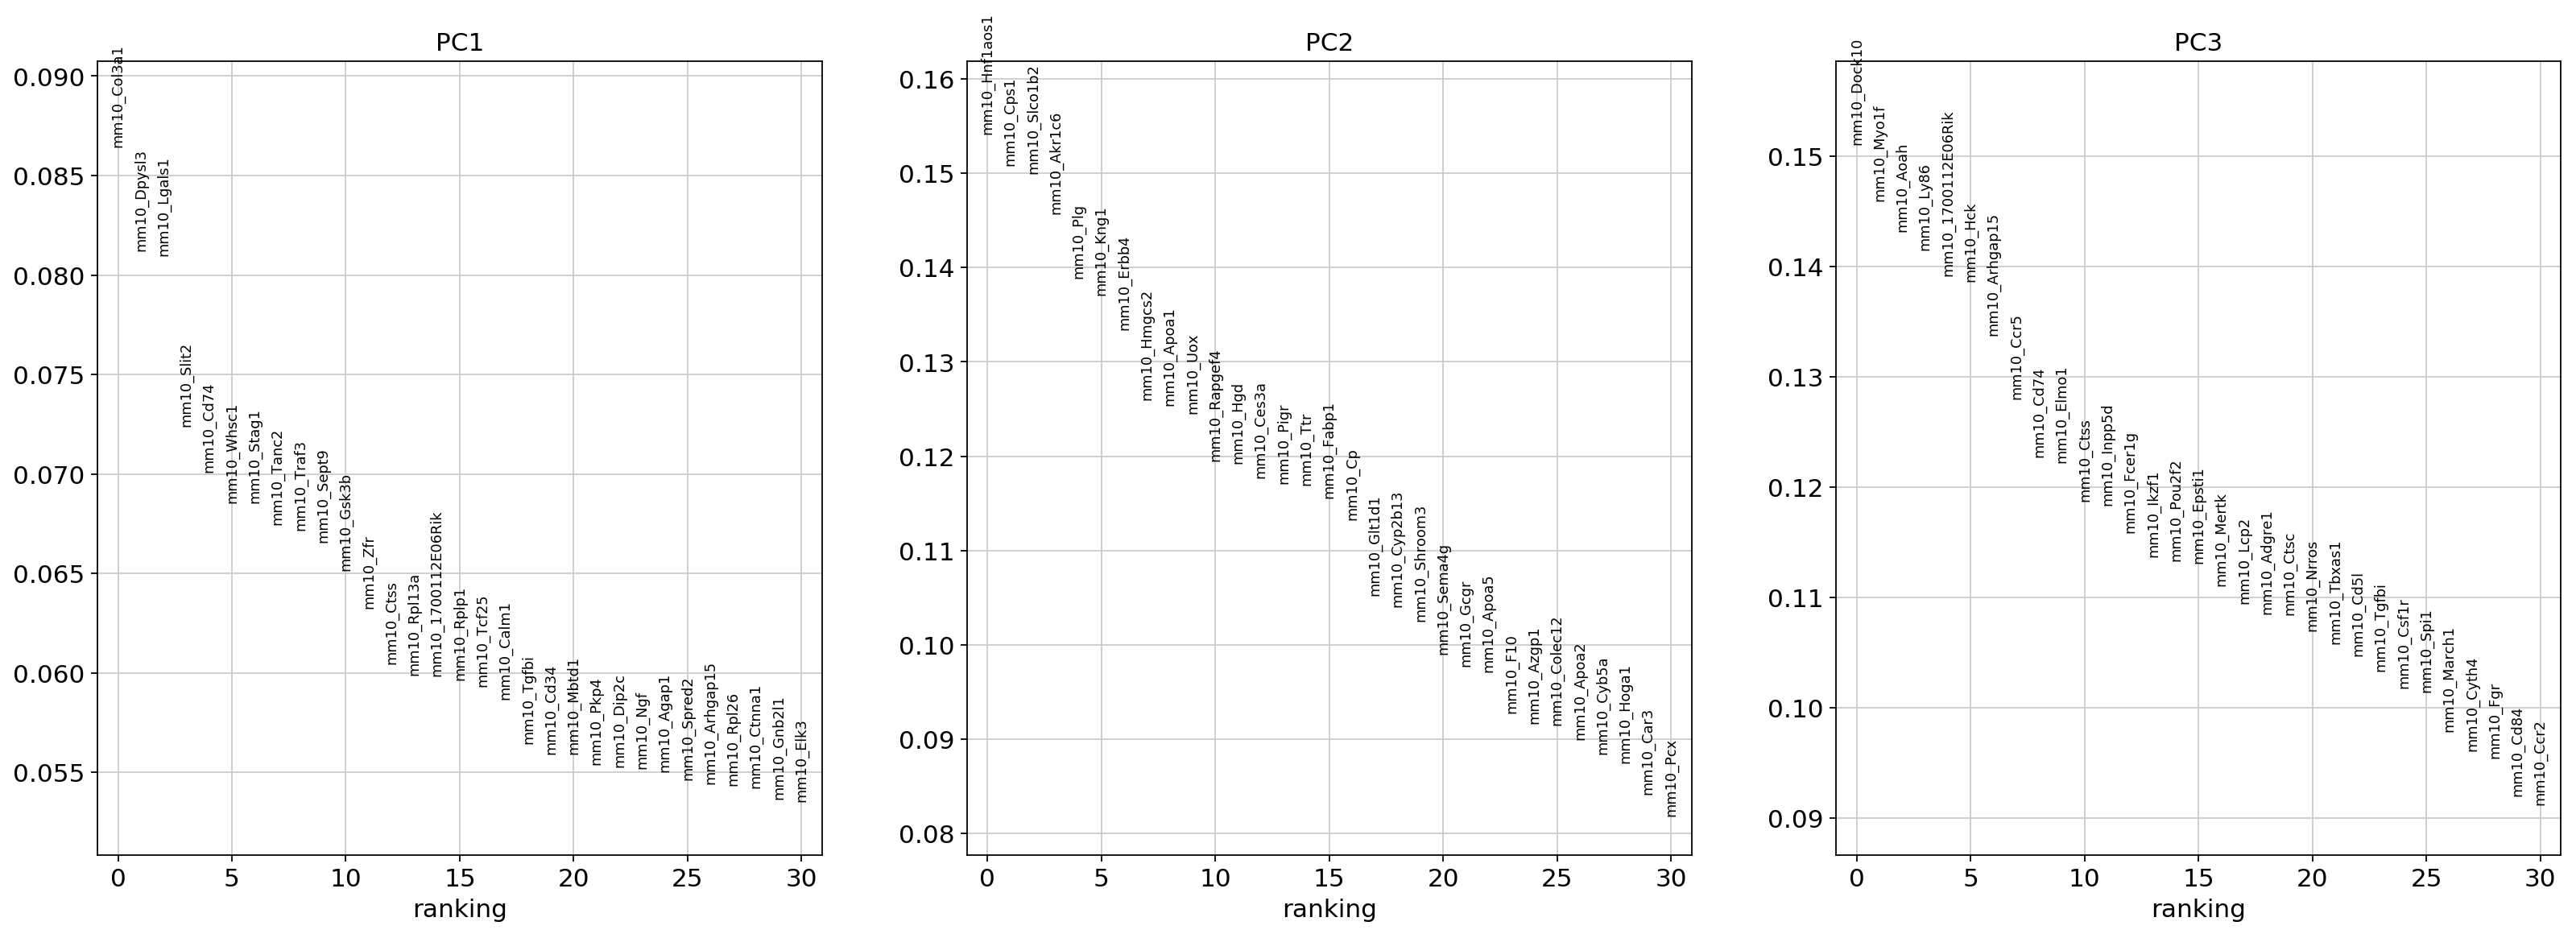

In [48]:
sc.pl.pca_loadings(adata)

In [49]:
sc.pp.neighbors(adata, n_neighbors=12, n_pcs=10)

computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 10
    computed neighbors (0:00:00)
    computed connectivities (0:00:04)
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:04)


In [50]:
sc.tl.leiden(adata, resolution=0.6)

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [51]:
# sc.tl.louvain(adata, resolution=0.8)

In [52]:
sc.tl.umap(adata,
            min_dist=.1,
            spread=2,
            alpha=2,
            )

computing UMAP
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


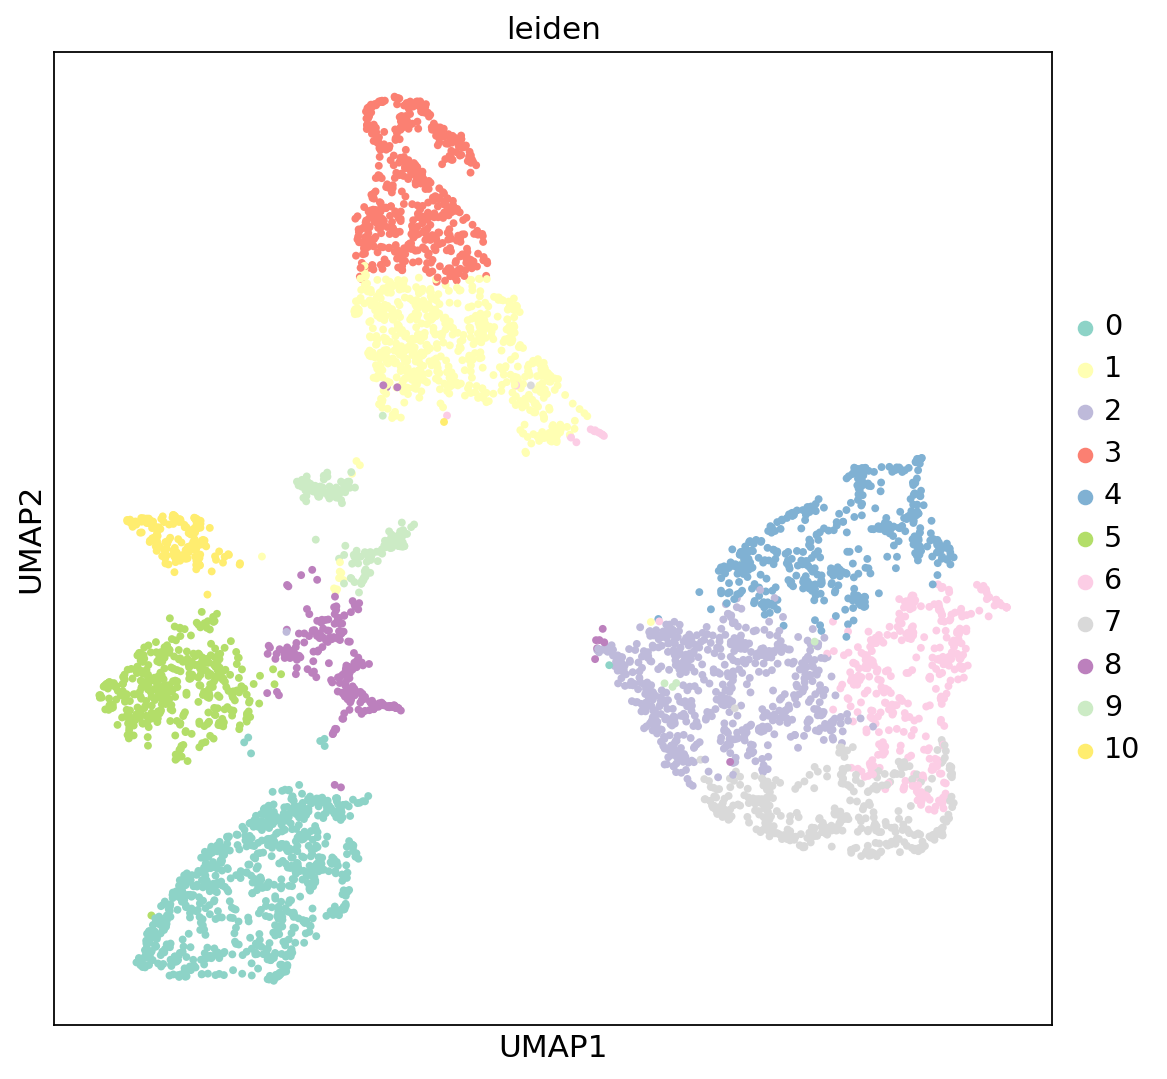

In [53]:
plt.rcParams['figure.figsize'] = [8, 8]

sc.pl.umap(adata, 
           color=['leiden'],
           ncols=1,
           palette="Set3",
           color_map=mpl.cm.CMRmap,
      #     legend_loc='on data',
           size=50)

Okay, weirdly it looks extremely similar but not identical to Derek's UMAP. I've run it a few times and (I don't think) it's due to random seed. Should figure out what the discrepancies are. Lymphocytes look slightly different.

In [54]:
ctdict = dict()
ctdict['Hepatocyte'] = [1, 3]
ctdict['Hek293t'] = [2, 4, 6, 7]
ctdict['Macrophage'] = [5]
ctdict['Kupffer'] = [10]
ctdict['LSECs'] = [9]
ctdict['Lymphocyte'] = [8]
ctdict['mc38'] = [0]
adata.obs['celltype'] = adata.obs['leiden']
for ct in ctdict:
    for clust in ctdict[ct]:
        adata.obs['celltype'].replace(r'^%s$' % str(clust),ct, regex=True, inplace=True)
adata.obs['celltype'] = adata.obs['celltype'].astype('category')

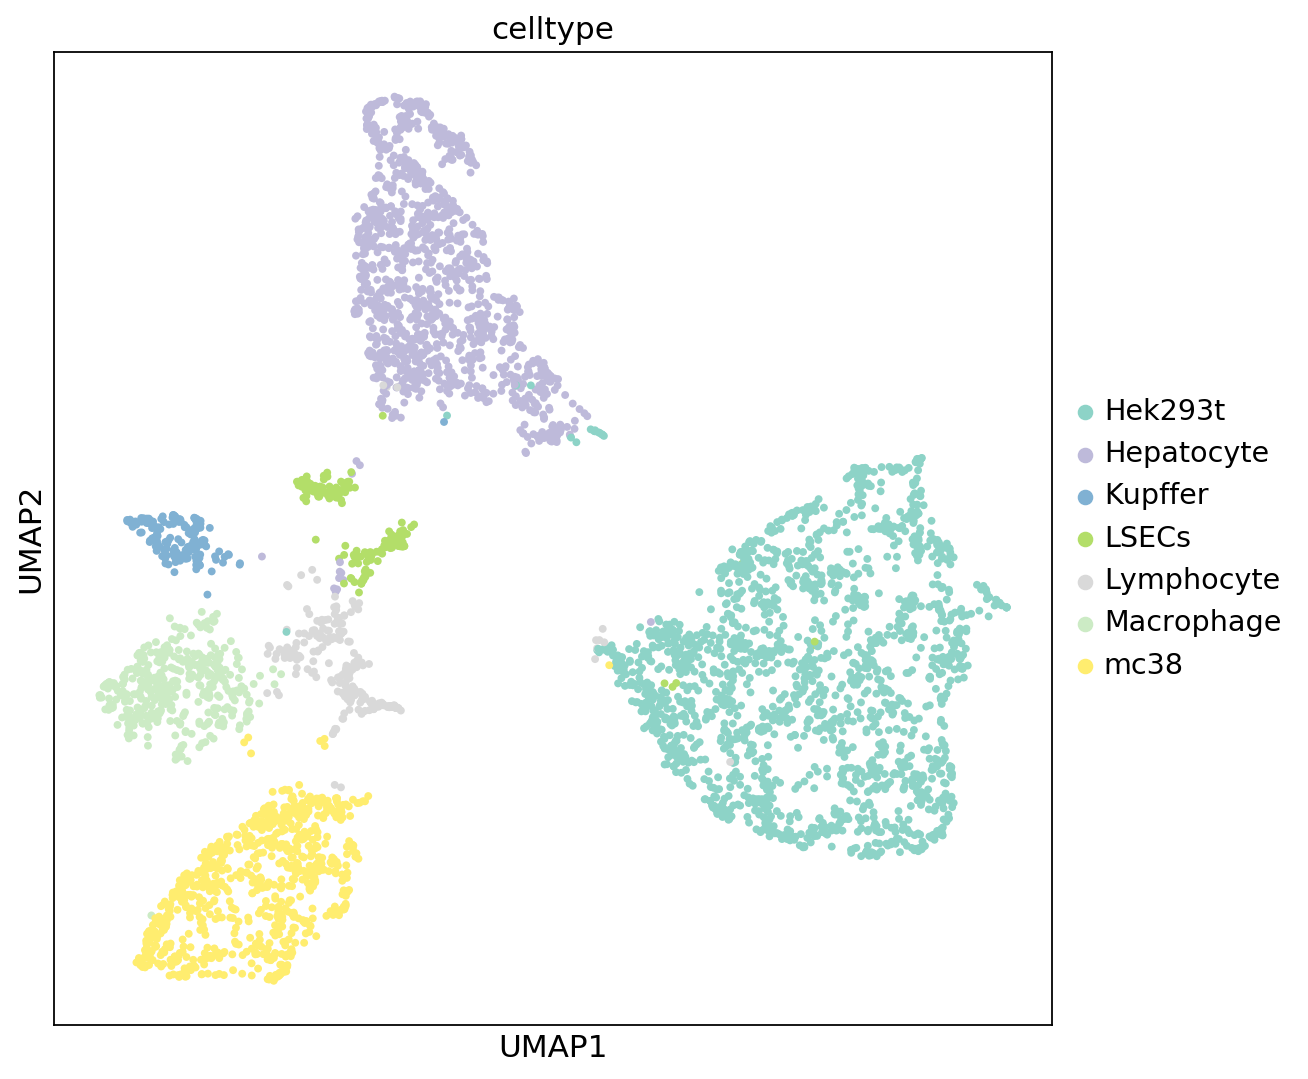

In [55]:
plt.rcParams['figure.figsize'] = [8, 8]

sc.pl.umap(adata, 
           color=['celltype'],
           ncols=1,
           palette="Set3",
           color_map=mpl.cm.CMRmap,
      #     legend_loc='on data',
           size=50)

In [56]:
adata.uns['celltype_colors'] =  ['#D9D9D9', '#FB8072', '#FFED6F', '#B3DE69', '#BC80BD', '#FDB462', '#80B1D3'] # got from Derek's Slack Message

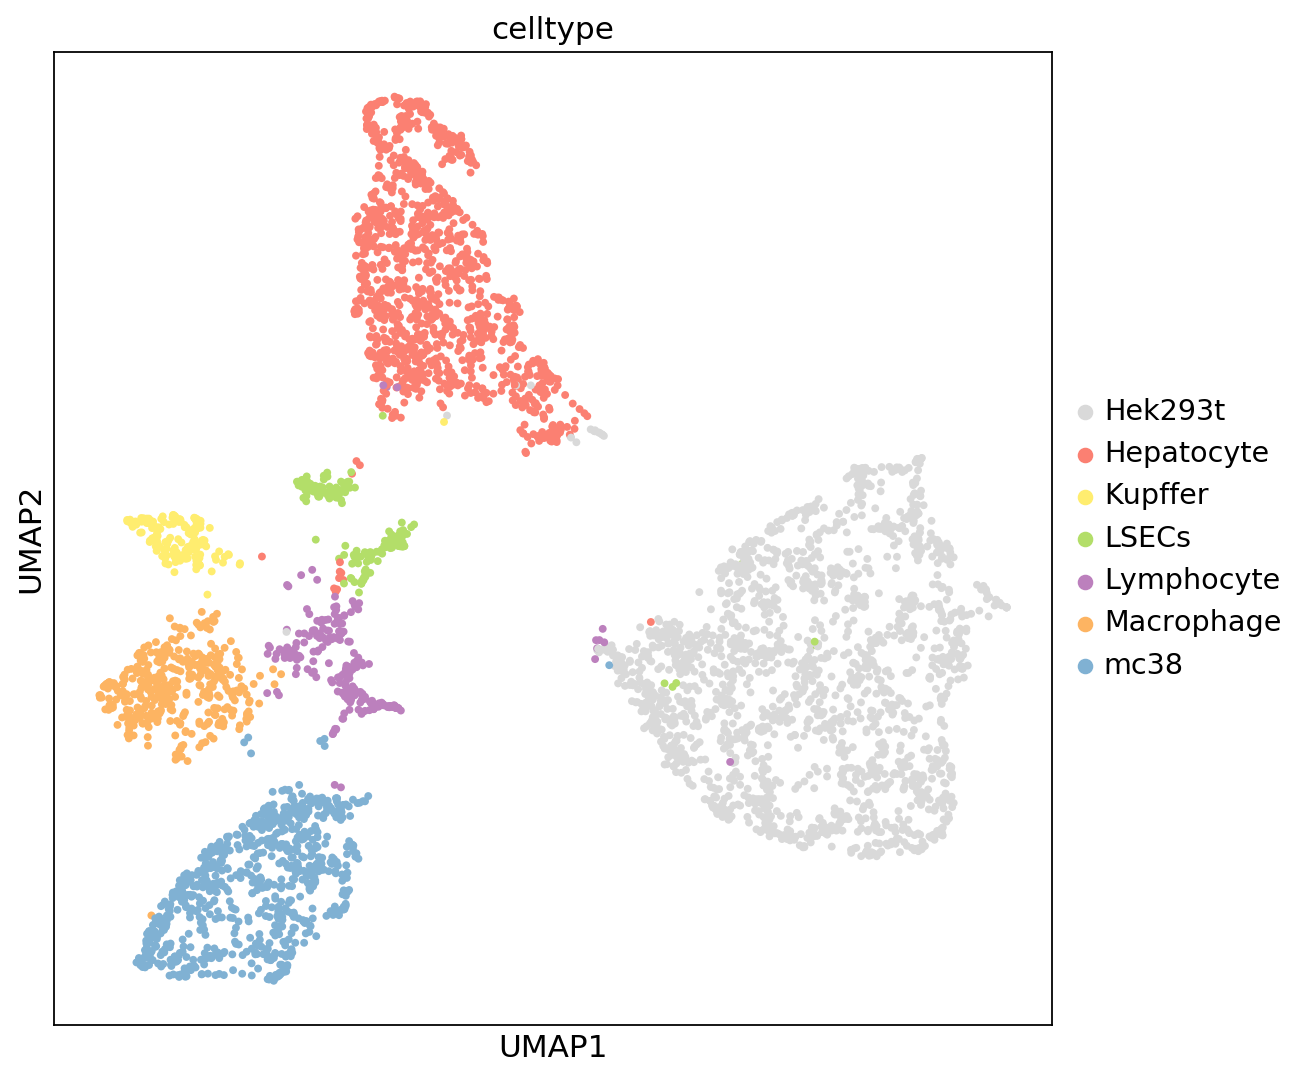

In [57]:
plt.rcParams['figure.figsize'] = [8, 8]
sc.pl.umap(adata, color=['celltype'], ncols=1, size=50)

/home/ghartoularos/anaconda3/envs/xyzeq/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:223: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


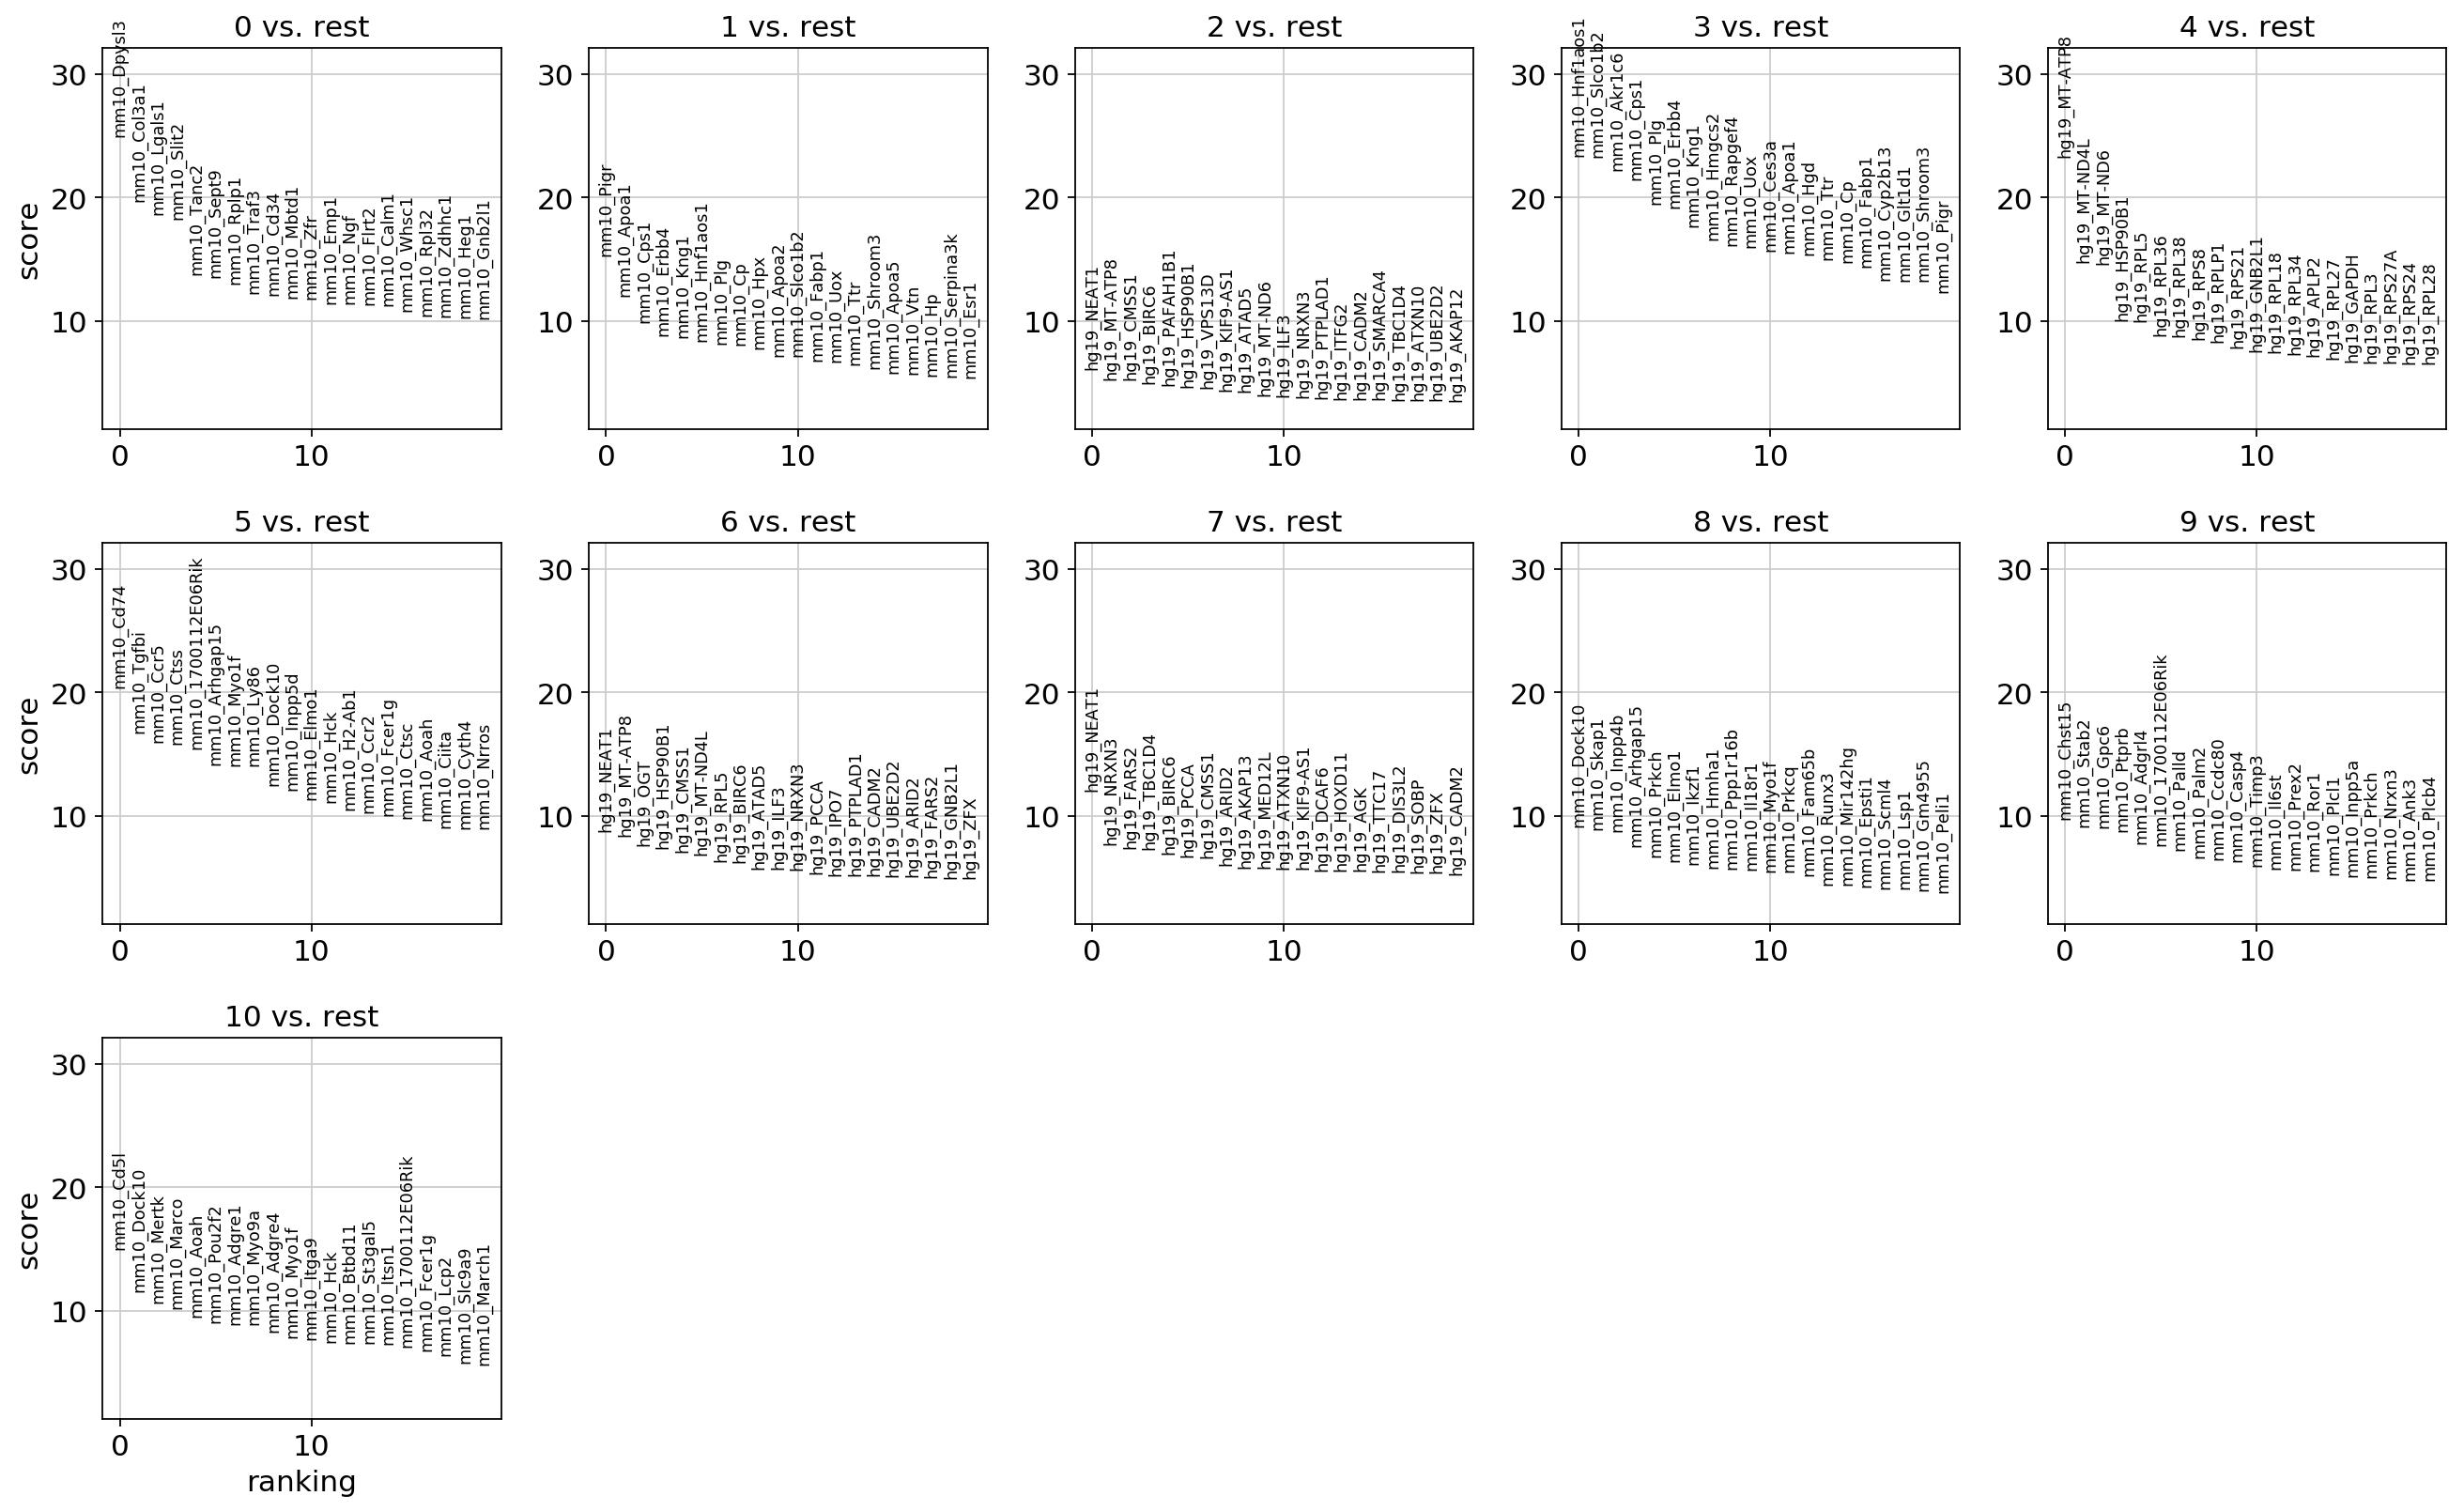

In [7]:
sc.settings.verbosity = 0 
sc.tl.rank_genes_groups(adata, groupby='leiden')
sc.pl.rank_genes_groups(adata, ncols=5)
sc.settings.verbosity = 3

In [5]:
# adata.write_h5ad(prefix + 'fig3.L20C1/adata.6.h5ad')
adata = sc.read_h5ad(prefix + 'fig3.L20C1/adata.6.h5ad')